In [1]:
using DrWatson
@quickactivate

In [2]:
using main
using BlockDiagonals, LinearAlgebra, Plots, ProgressMeter
using Distributions, MCMCChains, Random

gr(fmt=:png, levels=5, lw=0.5, msa=0.1, msw=0.5, ma=0.2, msc=:firebrick1, legend=:topright)
ProgressMeter.ijulia_behavior(:clear);

In [3]:
function generate_model(; m = 5.0 ,s = 0.5, d = 10)
    R = prod(
        [
        BlockDiagonal(
            [diagm(ones(2j)),
            [0.0 -1.0; 1.0 0.0],
            diagm(ones(d - 2j - 2))]
        ) for j in 0:round(Int, d / 2 - 1)
    ]
    )

    Σ₁ = [s^abs(i - j) for i in 1:d, j in 1:d]
    Σ₂ = R * Σ₁ * R'
    μ = [-m .* ones(d), m .* ones(d)]
    Σ = [Σ₁, Σ₂]

    ξ = MixtureModel(
        [MvNormal(x, y) for (x, y) in zip(μ, Σ)],
        [0.5, 0.5]
    )
    return Model(ξ=ξ)
end

generate_model (generic function with 1 method)

In [4]:
function acfplots(chains, names, lags=0:2:20; kwargs...)
    plt = plot(0, 0)
    for (x, n) in zip(chains, names)
        plt = plot(plt, mean(1 .* (autocor(x, lags=[lags...])[:, :]), dims=1)', label=n; kwargs...)
    end
    return plt
end

function scatterplots(xs, names; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 2, replace=false)
    plts = [scatter(baseplt, x[:, ds[1]], x[:, ds[2]], label=names[i]) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts..., axes=false, ticks=false; kwargs...)
end

function traceplots(xs, names, args...; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 1, replace=false)
    plts = [plot(x[:, ds[1]], label=names[i]; args...) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts...; kwargs...)
end

function scatterplot(x; baseplt=plot(0,0,label=""), kwargs...)
    plt = plot(baseplt, x |> m2t, c=:black, lw=0.1, la=0.25, label="")
    plt = scatter(plt, x |> m2t, c=:orange; kwargs...)
    return plt
end

function mean_ess(chains)
    return [ess_rhat(chn)[:, 2] |> mean for chn in chains]
end

function w2_minibatch(xs, model; eps=0.1, iters=100, k=100, N=64)
    results = zeros(length(xs))
    for (i, x) in zip(eachindex(xs), xs)
        z = Matrix(rand(model.ξ, size(x, 1))')
        results[i] = W2_minibatch(x, z, eps=eps, iters=iters, k=k, N=N)
    end
    return results
end

w2_minibatch (generic function with 1 method)

<br><br><br>
---
# Example: $\mathbb R^{2}$

In [5]:
model = generate_model(d=2);

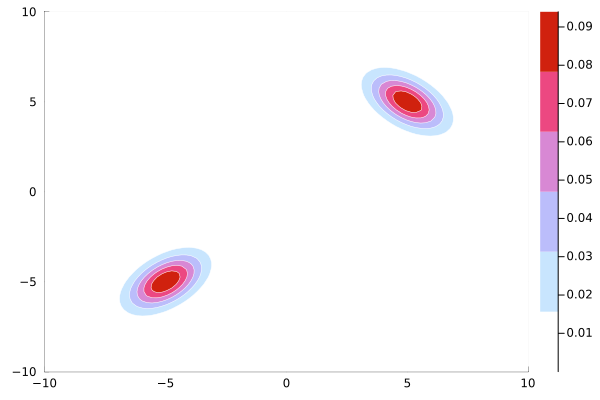

In [6]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)
plt(; lim=(-10, 10)) = contourf(
    repeat([range(lim..., length=100)], 2)..., 
    (x, y) -> model.f([x; y])^(1-1e-2), 
    c=cls
)
plt2 = plt()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
  HMC(0.5592119423038205, 18, Any[]):  0.9490101979604079


Acceptance Ratio = 0.9495
 27.541179 seconds (48.32 M allocations: 2.523 GiB, 3.28% gc time, 92.02% compilation time: 0% of which was recompilation)


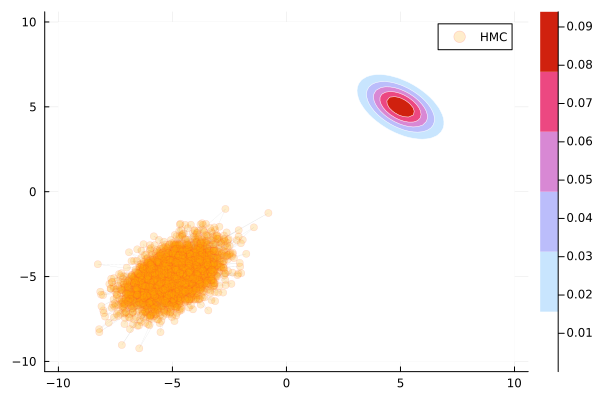

In [7]:
@time s1, a1 = mcmc(
    DualAverage(λ=10, δ=0.65),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_hmc = s1[a1, :]
chain_hmc = Chains(x_hmc)
plt2_hmc = scatterplot(x_hmc[:, 1:2], baseplt=plt(), label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
  HaRAM(0.5059293596888503, 40, 0.5443935901849325, Any[]):  0.6020795840831834


Acceptance Ratio = 0.6014
 10.444353 seconds (39.52 M allocations: 2.192 GiB, 5.44% gc time, 9.93% compilation time)


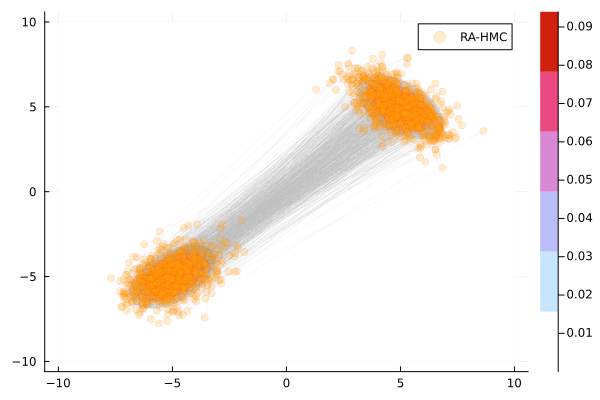

In [8]:
@time s2, a2 = mcmc(
    DualAverage(λ=20, δ=0.65),
    HaRAM(),
    model; n=5e3, n_burn=1e3
)
x_haram = s2[a2, :]
chain_haram = Chains(x_haram)
plt2_haram = scatterplot(x_haram[:, 1:2], baseplt=plt(), label="RA-HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(MvNormal{Int64, PDMats.ScalMat{Int64}, FillArrays.Zeros{Int64, 1, Tuple{Base.OneTo{Int64}}}}(
dim: 2
μ: Zeros(2)
Σ: [16 0; 0 16]
)
, [-1.2301358794202484, 2.110181464588674], Any[]):       0.2132977837027162


Acceptance Ratio = 0.2117
  1.278500 seconds (2.88 M allocations: 153.792 MiB, 3.61% gc time, 89.91% compilation time)


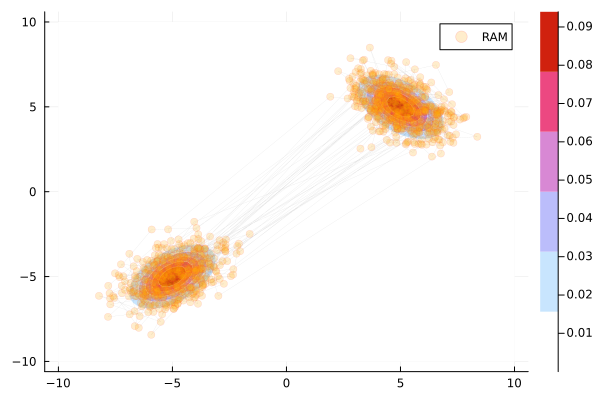

In [9]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 4), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_ram = s3[a3, :]
chain_ram = Chains(x_ram)
plt2_ram = scatterplot(x_ram[:, 1:2], baseplt=plt(), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:02:48
  PEHMC:  0.29427792915531337


Acceptance Ratio = 0.3114
169.187940 seconds (547.38 M allocations: 23.760 GiB, 3.19% gc time, 19.01% compilation time)


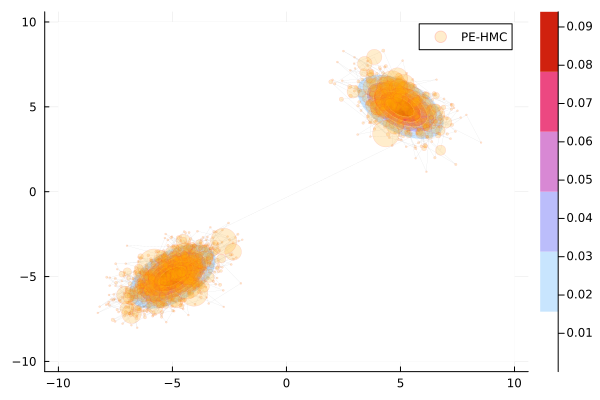

In [10]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.85, L=25, N=3),
    model; n=1e3, n_burn=1e2
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_pehmc = Chains(x_pehmc)
plt2_pehmc = scatterplot(x_pehmc, baseplt=plt(), ms=exp.(3 .* w_pehmc), label="PE-HMC")

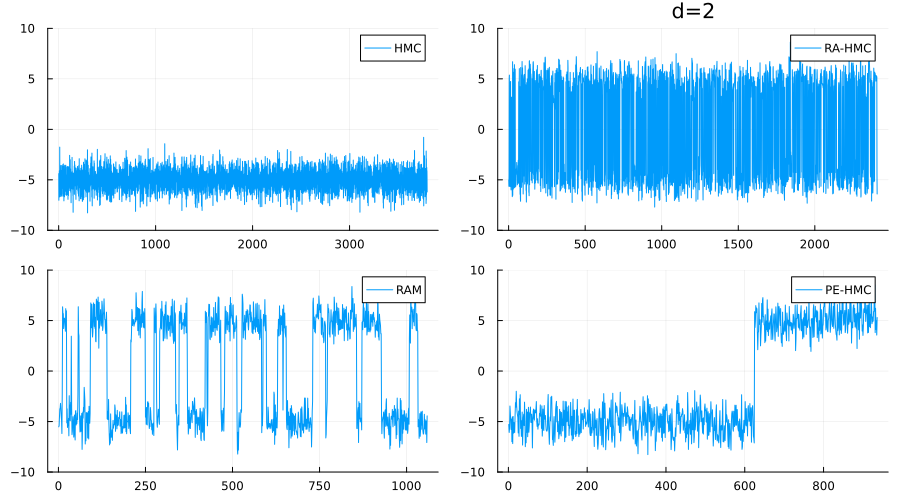

In [11]:
names = ("HMC", "RA-HMC", "RAM", "PE-HMC")
xs2d = [x_hmc, x_haram, x_ram, x_pehmc]
chains2d = [chain_hmc, chain_haram, chain_ram, chain_pehmc];

plt2_tr = traceplots(xs2d, names, lw=1, layout=(2,2), ylim=(-10,10), l=100, size=(900, 500), title=["" "d=2" "" ""])

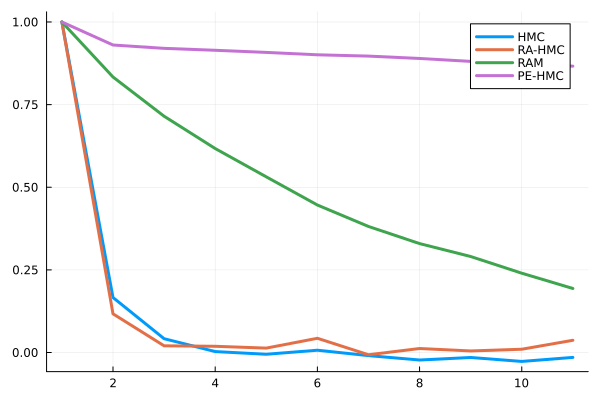

In [12]:
plt2_acf = acfplots(chains2d, names, lw=3)

In [13]:
w2_minibatch(xs2d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


4-element Vector{Float64}:
 0.2769397472912526
 0.014261261041586908
 0.036761465779609544
 0.05255084063204357

<br><br><br>
---
# Example: $\mathbb R^{10}$

In [14]:
model = generate_model(d=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
  HMC(0.9002372035822539, 11, Any[]):  0.638590352411897


Acceptance Ratio = 0.6432
  3.255877 seconds (6.53 M allocations: 2.287 GiB, 6.60% gc time, 27.38% compilation time)


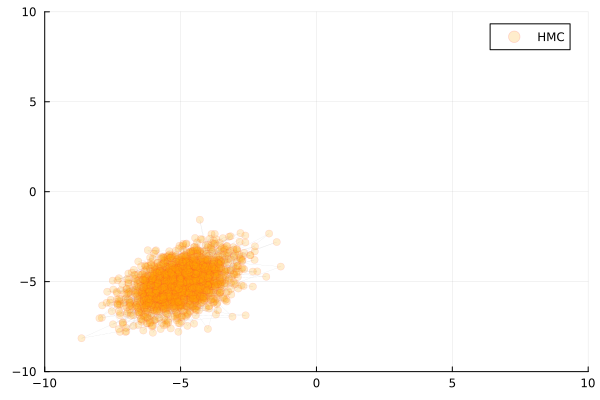

In [15]:
@time s1, a1 = mcmc(
    DualAverage(λ=10, δ=0.6),
    HMC(),
    model; n=4e3, n_burn=1e3
)
x_10_hmc = s1[a1, :]
chain_10_hmc = Chains(x_10_hmc)
plt10_hmc = scatterplot(x_10_hmc[:, 1:2], lim=(-10, 10), label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:23
  HaRAM(0.14089103517325322, 284, 0.11866008948012777, Any[]):  0.8315421144713822


Acceptance Ratio = 0.8309
 83.446647 seconds (165.17 M allocations: 80.873 GiB, 7.58% gc time)


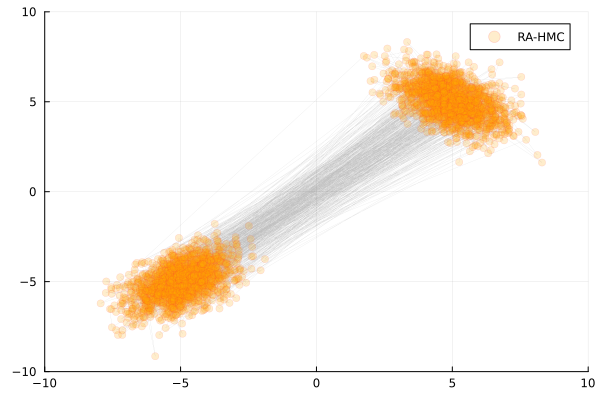

In [16]:
@time s2, a2 = mcmc(
    DualAverage(λ=40, δ=0.6),
    HaRAM(),
    model; n=4e3, n_burn=1e2
)
x_10_haram = s2[a2, :]
chain_10_haram = Chains(x_10_haram)
plt10_haram = scatterplot(x_10_haram[:, 1:2], lim=(-10, 10), label="RA-HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(MvNormal{Int64, PDMats.ScalMat{Int64}, FillArrays.Zeros{Int64, 1, Tuple{Base.OneTo{Int64}}}}(
dim: 10
μ: Zeros(10)
Σ: [1 0 0 0 0 0 0 0 0 0; 0 1 0 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 0 0 0; 0 0 0 1 0 0 0 0 0 0; 0 0 0 0 1 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0; 0 0 0 0 0 0 1 0 0 0; 0 0 0 0 0 0 0 1 0 0; 0 0 0 0 0 0 0 0 1 0; 0 0 0 0 0 0 0 0 0 1]
)
, [-0.044976322179411735, -0.6797020310492257, 0.8938593012024777, 0.12860621112598183, -0.8110756917290858, -1.1043165431978625, 1.3248101803304355, -0.04281226652377521, 0.9681070637387665, -0.9569667795761488], Any[]):       0.11437712457508498


Acceptance Ratio = 0.1114
  0.239478 seconds (1.07 M allocations: 79.455 MiB, 8.07% gc time)


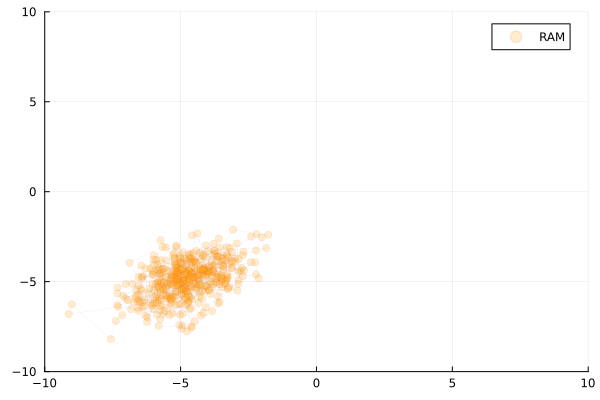

In [17]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 1), z=randn(model.d)),
    model; n=4e3, n_burn=1e3
)
x_10_ram = s3[a3, :]
chain_10_ram = Chains(x_10_ram)
plt10_ram = scatterplot(x_10_ram[:, 1:2], lim=(-10, 10), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02
  PEHMC:  0.6112624886466849


Acceptance Ratio = 0.6287
 62.548330 seconds (208.28 M allocations: 9.726 GiB, 3.10% gc time)


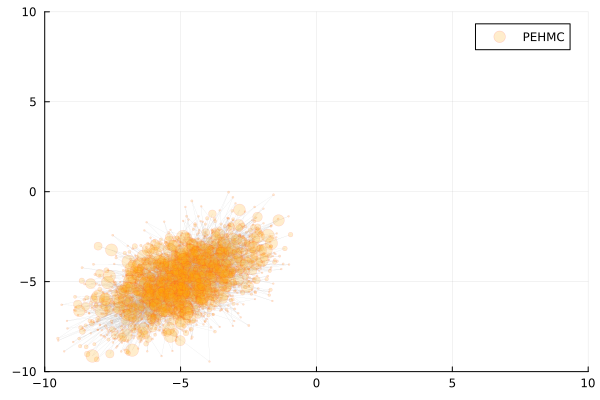

In [22]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.35, L=10, N=3),
    model; n=1e3, n_burn=1e2
)
x_10_pehmc, w_10_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_10_pehmc = Chains(x_10_pehmc)
plt10_pehmc = scatterplot(x_10_pehmc[:, 1:2], ms=exp.(2 .* w_10_pehmc), lim=(-10, 10), label="PEHMC")

In [23]:
xs10d = [x_10_hmc, x_10_haram, x_10_ram, x_10_pehmc]
chains10d = [chain_10_hmc, chain_10_haram, chain_10_ram, chain_10_pehmc];

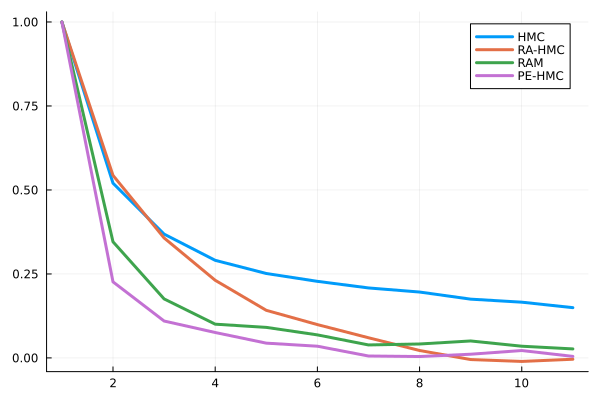

In [24]:
plt10_acf = acfplots(chains10d, names, lw=3)

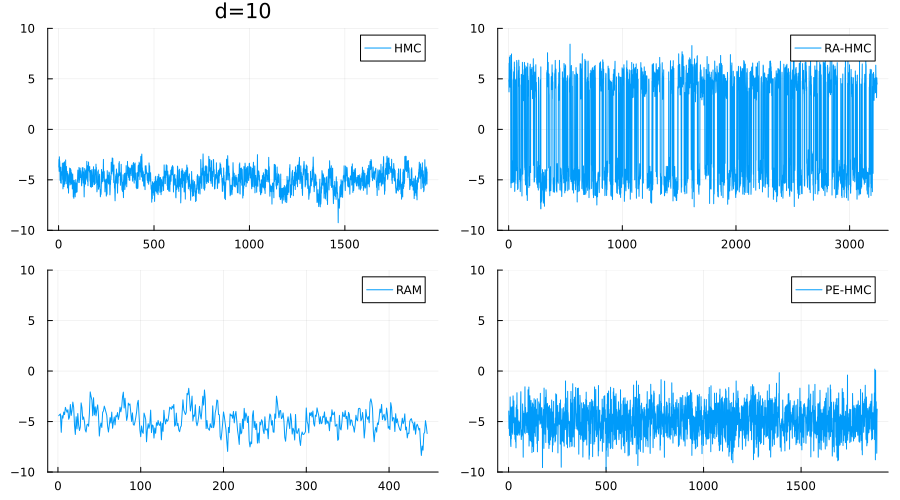

In [25]:
plt10_tr = traceplots(xs10d, names, lw=1, layout=(2,2), ylim=(-10,10), l=100, size=(900, 500), title=["d=$(model.d)" "" "" ""])

In [26]:
w2_minibatch(xs10d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


4-element Vector{Float64}:
 1.8960876311887769
 0.14836914969468096
 5.553444536604368
 1.6802957076678795

<br><br><br>
---
# Example: $\mathbb R^{20}$

In [27]:
model = generate_model(d=20);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
  HMC(0.7792063659802295, 26, Any[]):  0.6284743051389722


Acceptance Ratio = 0.6252
 25.436714 seconds (17.88 M allocations: 45.773 GiB, 8.34% gc time, 3.80% compilation time)


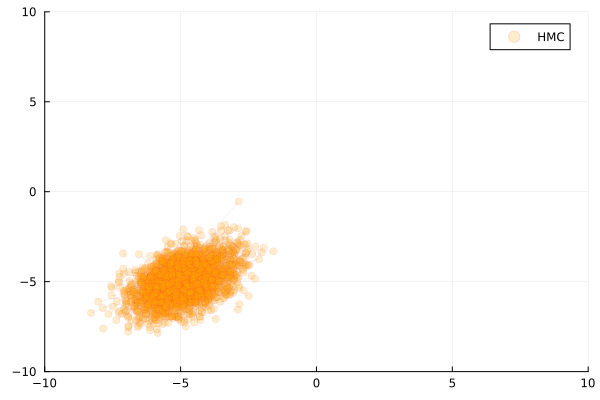

In [28]:
@time s1, a1 = mcmc(
    DualAverage(λ=20, δ=0.6),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_20_hmc = s1[a1, :]
chain_20_hmc = Chains(x_20_hmc)
plt20_hmc = scatterplot(x_20_hmc[:, 1:2], lim=(-10, 10), label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:24:15
  HaRAM(0.058101876511371324, 861, 0.11343726333820302, Any[]):  0.7630473905218956


Acceptance Ratio = 0.7681
1455.438525 seconds (972.79 M allocations: 2.688 TiB, 8.66% gc time)


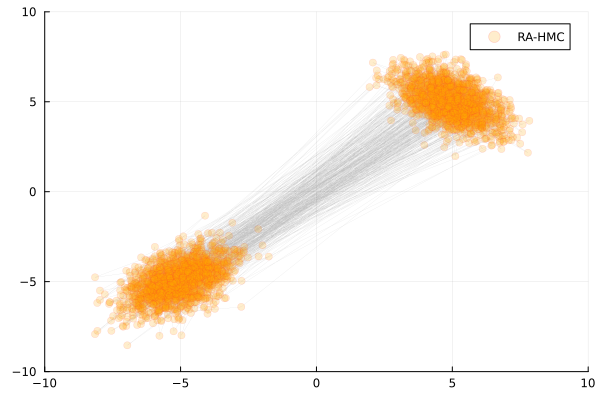

In [29]:
@time s2, a2 = mcmc(
    DualAverage(λ=50, δ=0.6),
    HaRAM(),
    model; n=5e3, n_burn=1e3
)
x_20_haram = s2[a2, :]
chain_20_haram = Chains(x_20_haram)
plt20_haram = scatterplot(x_20_haram[:, 1:2], lim=(-10, 10), label="RA-HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 20
μ: Zeros(20)
Σ: [0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0

Acceptance Ratio = 0.1781
  0.655423 seconds (1.51 M allocations: 141.205 MiB, 46.19% compilation time)


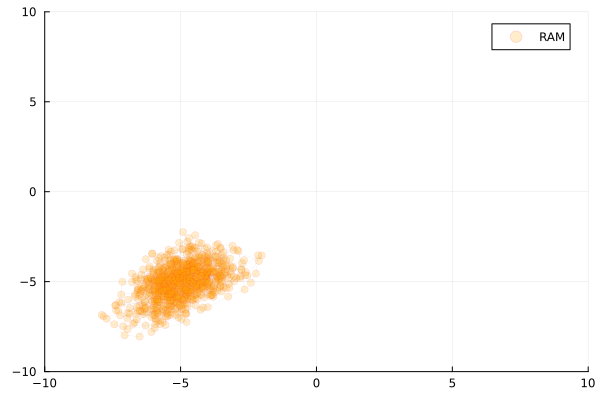

In [30]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.5), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_20_ram = s3[a3, :]
chain_20_ram = Chains(x_20_ram)
plt20_ram = scatterplot(x_20_ram[:, 1:2], lim=(-10, 10), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:42
  PEHMC:  0.2633969118982743


Acceptance Ratio = 0.2764
102.432372 seconds (341.19 M allocations: 19.535 GiB, 3.17% gc time)


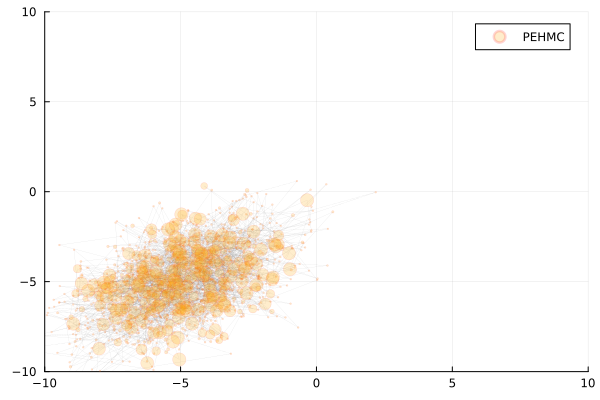

In [31]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.25, L=10, N=5),
    model; n=1e3, n_burn=1e2
)
x_20_pehmc, w_20_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_20_pehmc = Chains(x_20_pehmc)
plt20_pehmc = scatterplot(x_20_pehmc[:, 1:2], ms=exp.(2 .* w_20_pehmc), lim=(-10, 10), label="PEHMC")

In [32]:
xs20d = [x_20_hmc, x_20_haram, x_20_ram, x_20_pehmc]
chains20d = [chain_20_hmc, chain_20_haram, chain_20_ram, chain_20_pehmc];

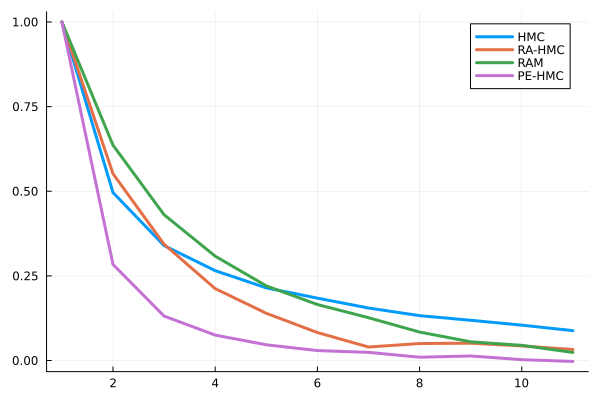

In [33]:
plt20_acf = acfplots(chains20d, names, lw=3)

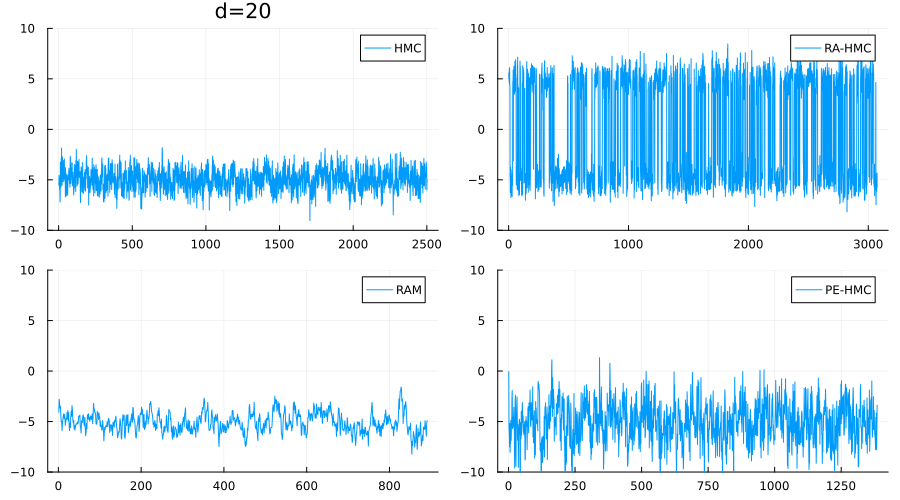

In [34]:
plt20_tr = traceplots(xs20d, names, lw=1, layout=(2,2), ylim=(-10,10), l=100, size=(900, 500), title=["d=$(model.d)" "" "" ""])

In [35]:
w2_minibatch(xs20d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


4-element Vector{Float64}:
 2.3836002539278343
 0.43163810611316167
 6.992152221633011
 4.765443078649102

<br><br><br><br><br><br>
---

In [38]:
# d2 = [
#     "plt2_tr", "plt2_acf", 
#     "plt2_hmc", "plt2_haram", "plt2_ram", "plt2_pehmc"
# ] 
# d10= [
#     "plt10_tr", "plt10_acf", 
#     "plt10_hmc", "plt10_haram", "plt10_ram", "plt10_pehmc",
# ]
# d20= [
#     "plt20_tr", "plt20_acf", 
#     "plt20_hmc", "plt20_haram", "plt20_ram", "plt20_pehmc",
# ]

# using Pipe
# @pipe [d2; d10; d20].|> 
# begin 
#     plot(eval(Meta.parse(_))); savefig.(plotsdir.("new/gaussian3/d/" .* _ .* [".pdf", ".svg"] )) 
# end;